In [1]:
import os
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import json
from pathlib import Path

In [2]:
import pickle
def load_graph(fn):
    with open(fn, "rb") as f:
        return pickle.load(f)
filenames = [fn for fn in os.listdir("../../graphs/") if ".pkl" in fn]
graphs = [load_graph("../../graphs/"+fn) for fn in filenames]
graphs_by_id = {graph.nodes[list(graph.nodes)[0]]["full_id"][0]:graph for graph in graphs}

In [3]:
files = list(Path("../../if/pfam/").glob("*.json"))
coverages = []
duplicate_mentions_in_domain = 0
duplicate_mentions = 0
family_chain = {}
break_on_duplicated_domain_chain = False
debug=False
for file in files:
    with open(file) as f:
        data = json.load(f)
    if debug:
        print(json.dumps(data, indent=1))
        break
    domains = data[file.stem.lower()]["Pfam"]
    
    mentioned_chains = set()
    for domain, info in domains.items():
        coverages.extend([mapping["coverage"] for mapping in info["mappings"]])
        #remove duplicated mappings
        mappings = []
        for mapping in info["mappings"]:
            # Since dicts are not easily hashable, we just compare them
            # using 'in' (which checks equality for all elements)
            if mapping not in mappings:
                mappings.append(mapping)
        
        mentioned_chains_domain = set()
        for mapping in mappings:#info["mappings"]:
            family_chain[domain] = family_chain.get(domain, set())
            family_chain[domain].add(file.stem.upper()+"_"+mapping["chain_id"])
            
            if mapping["chain_id"] in mentioned_chains and mapping["chain_id"] not in mentioned_chains_domain:
                duplicate_mentions+=1
                if break_on_duplicated_domain_chain:
                    print(json.dumps(data, indent=1))
                    raise ValueError("Mapping domain=>chain is not injective")
            mentioned_chains.add(mapping["chain_id"])
            if mapping["chain_id"] in mentioned_chains_domain:
                duplicate_mentions_in_domain+=1
                
            mentioned_chains_domain.add(mapping["chain_id"])

import scipy.stats
print(scipy.stats.describe(coverages))
print(duplicate_mentions)
print(duplicate_mentions_in_domain)

DescribeResult(nobs=8350, minmax=(0.251, 1.0), mean=0.9986822754491017, variance=0.0006523413674411868, skewness=-25.84646048665647, kurtosis=721.0746342336738)
2803
595


Text(0, 0.5, 'Frequency')

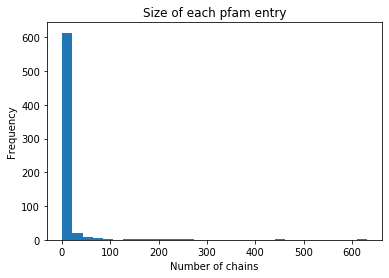

In [5]:
longs = {family_chain:len(chains) for family_chain, chains in family_chain.items()}
plt.hist(longs.values(), bins=30)
plt.title("Size of each pfam entry")
plt.xlabel("Number of chains")
plt.ylabel("Frequency")

In [ ]:
#Tengo que tomar el top 10, pero DISJUNTOS.

In [6]:
top10_familias = sorted(longs.keys(), key=longs.__getitem__, reverse=True)[0:10]
top10_familias

['PF00137',
 'PF02874',
 'PF00006',
 'PF00004',
 'PF00022',
 'PF00306',
 'PF00227',
 'PF17862',
 'PF00069',
 'PF00005']

In [7]:
problems = {}
blacklist = set()
for familia in top10_familias:
    if familia in blacklist: continue
    problems[familia] = 0
    for familia2 in top10_familias:
        if familia == familia2: continue
        if familia2 in blacklist: continue
        if len(family_chain[familia] & family_chain[familia2]) > 0:
            blacklist.add(familia2)
            print(f"{familia} and {familia2} have coincidences")
        
top_familias_disj = list(problems.keys())
problems

PF02874 and PF00006 have coincidences
PF02874 and PF00306 have coincidences
PF00004 and PF17862 have coincidences


{'PF00137': 0,
 'PF02874': 0,
 'PF00004': 0,
 'PF00022': 0,
 'PF00227': 0,
 'PF00069': 0,
 'PF00005': 0}

In [8]:
{familia:len(family_chain[familia]) for familia in top_familias_disj}

{'PF00137': 630,
 'PF02874': 459,
 'PF00004': 254,
 'PF00022': 240,
 'PF00227': 203,
 'PF00069': 168,
 'PF00005': 160}

In [9]:
family_subgraphs = {}
missing = 0
for familia in top_familias_disj:
    for chain in family_chain[familia]:
        graph_id = chain.split("_")[0]
        if graph_id not in graphs_by_id:
            missing += 1
            continue
            
        graph = graphs_by_id[graph_id]
        subgraph_nodes = []
        for node in graph.nodes:
            if graph.nodes[node]["chain"] == chain:
                subgraph_nodes.append(node)
        if len(subgraph_nodes) > 0:
            family_subgraphs[familia] = family_subgraphs.get(familia, [])
            family_subgraphs[familia].append(graph.subgraph(subgraph_nodes))

In [10]:
{familia:len(subgraphs) for familia, subgraphs in family_subgraphs.items()}

{'PF02874': 423,
 'PF00004': 123,
 'PF00022': 213,
 'PF00069': 155,
 'PF00005': 142}

In [11]:
for familia, subgraphs in family_subgraphs.items():
    for subgraph in subgraphs:
        if subgraph.number_of_nodes() == 0:
            print("oops")

In [12]:
family_id_name = {
    "PF02874": "ATP synthase alpha/beta",
    "PF00004": "ATPase",
    "PF00022": "Actin",
    "PF00069": "Protein kinase",
    "PF00005": "ABC transporter"
}

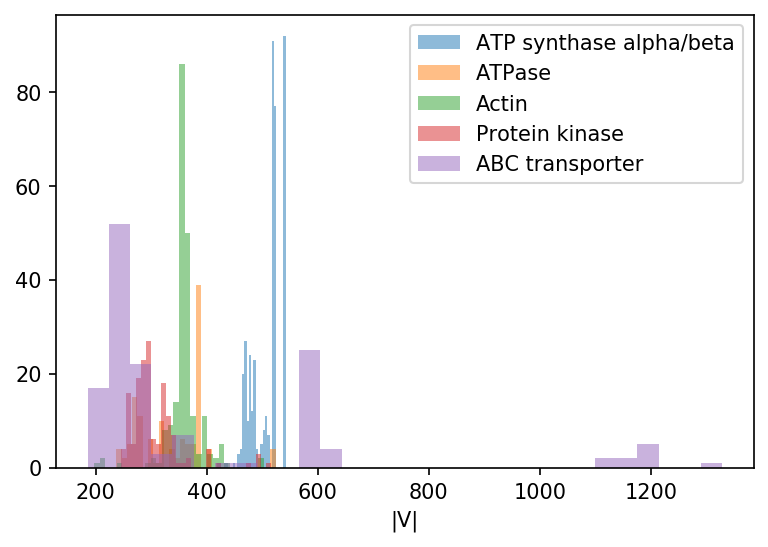

In [181]:
plt.figure(dpi=150)
for family, subgraphs in family_subgraphs.items():
    #if family == "PF00227": break
    plt.hist(
        [H.number_of_nodes() for H in subgraphs],
        bins=30,
        alpha=0.5,
        label=family_id_name[family]
    )
plt.xlabel("|V|")
#plt.ylabel("|E|")
plt.legend()

(500, 5000)

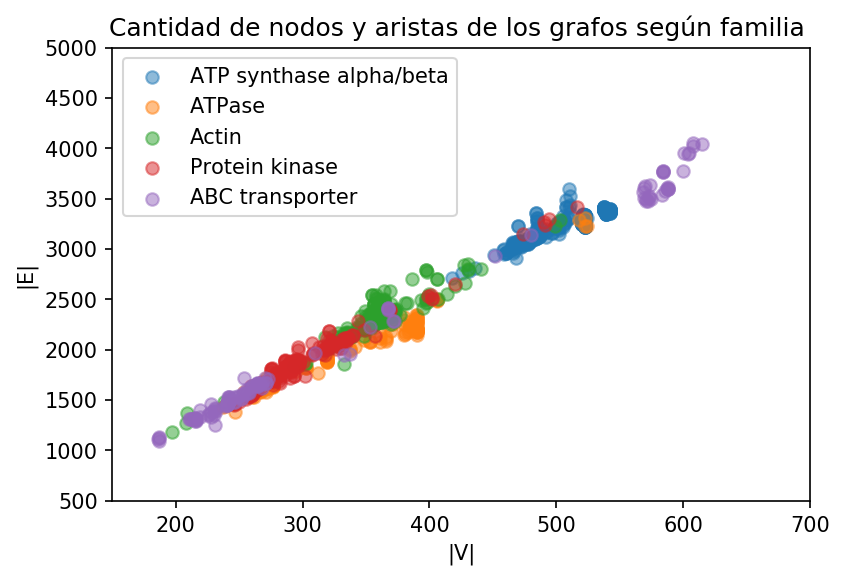

In [183]:
plt.figure(dpi=150)
for family, subgraphs in family_subgraphs.items():
    plt.scatter(
        [H.number_of_nodes() for H in subgraphs],
        [H.number_of_edges() for H in subgraphs],
        alpha=0.5,
        label=family_id_name[family]
    )
plt.title("Cantidad de nodos y aristas de los grafos según familia ")
plt.xlabel("|V|")
plt.ylabel("|E|")
plt.legend()
plt.xlim(150,700)
plt.ylim(500,5000)

0.022924610022440336
0.03107179328307689
0.023586764555631776
0.05113351927340342
0.025955525508849022
0.06302907618697093
0.02572439226311432
0.04908563048097932
0.010620477388075285
0.06514864010120178


(0, 0.07)

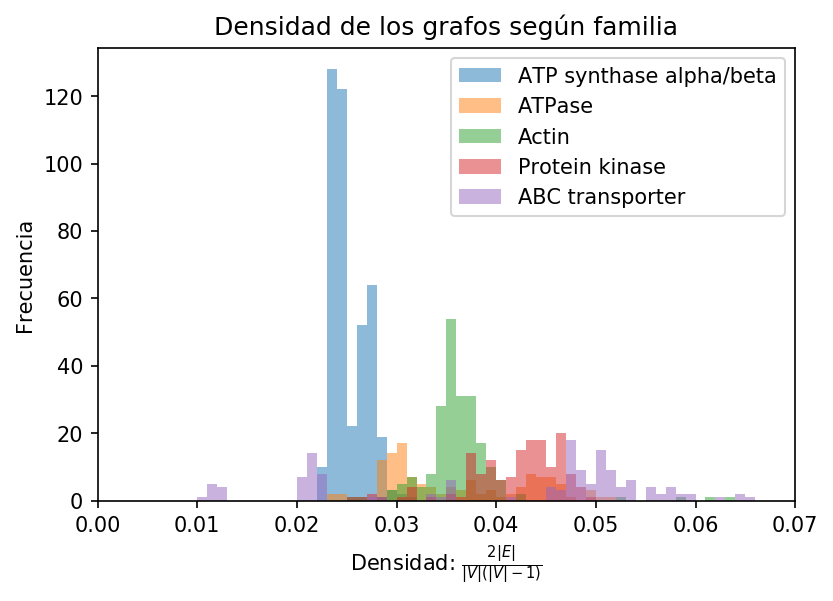

In [184]:
plt.figure(dpi=150, facecolor="white")
for family, subgraphs in family_subgraphs.items():
    #if family == "PF00227": break
    densities = [e for e in [nx.density(H) for H in subgraphs] if abs(e)<0.1]
    
    print(min(densities))
    print(max(densities))
    plt.hist(
        densities,
        bins=[i/1000 for i in range(100)],
        alpha=0.5,
        label=family_id_name[family]
    )
plt.xlabel(r"Densidad: $\frac{2|E|}{|V|(|V|-1)}$")
plt.ylabel("Frecuencia")
plt.title("Densidad de los grafos según familia")
plt.legend()
plt.xlim(0, 0.07)

In [191]:
%time print("hola")
%time print("hola")

hola
CPU times: user 39 µs, sys: 0 ns, total: 39 µs
Wall time: 42.4 µs
hola
CPU times: user 24 µs, sys: 0 ns, total: 24 µs
Wall time: 26 µs


CPU times: user 25min 29s, sys: 514 ms, total: 25min 29s
Wall time: 25min 31s
CPU times: user 41 s, sys: 2min 4s, total: 2min 45s
Wall time: 15.4 s
CPU times: user 3min 8s, sys: 606 ms, total: 3min 8s
Wall time: 3min 8s
CPU times: user 2.54 s, sys: 2.89 s, total: 5.43 s
Wall time: 1.78 s
CPU times: user 6min 5s, sys: 158 ms, total: 6min 5s
Wall time: 6min 5s
CPU times: user 4.48 s, sys: 3.12 s, total: 7.6 s
Wall time: 3.25 s
CPU times: user 3min 13s, sys: 167 ms, total: 3min 13s
Wall time: 3min 13s
CPU times: user 2.8 s, sys: 3.49 s, total: 6.29 s
Wall time: 2.08 s
CPU times: user 7min, sys: 166 ms, total: 7min 1s
Wall time: 7min 1s
CPU times: user 8.51 s, sys: 25.6 s, total: 34.1 s
Wall time: 3.32 s


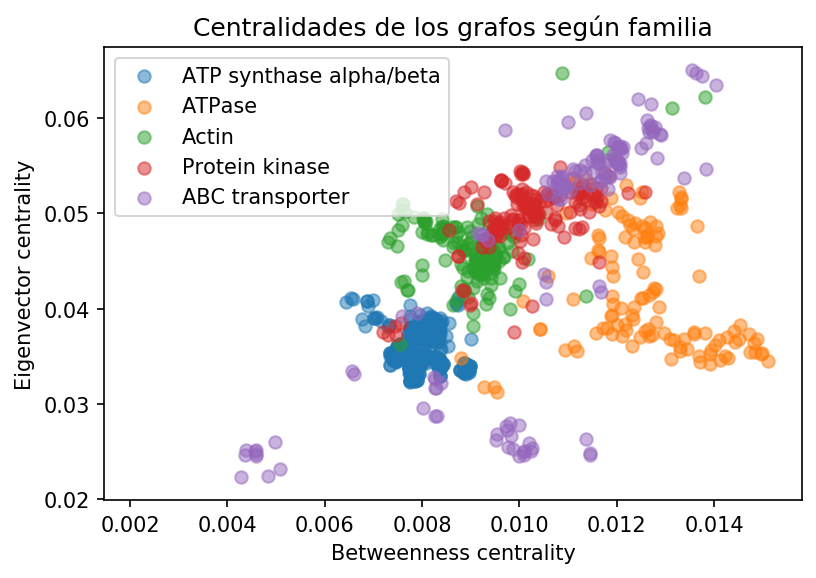

In [197]:
plt.figure(dpi=150, facecolor="white")
import progressbar
it = family_subgraphs.items()
#it = progressbar.ProgressBar()(it, max_value=len(family_subgraphs))
for family, subgraphs in it:
    
    #%time deg = [np.mean(list(nx.degree_centrality(H).values())) for H in subgraphs]
    %time btw = [np.mean(list(nx.betweenness_centrality(H).values())) for H in subgraphs]
    %time egv = [np.mean(list(nx.eigenvector_centrality_numpy(H).values())) for H in subgraphs]
    
    plt.scatter(
        #deg,
        btw,
        egv,
        alpha=0.5,
        label=family_id_name[family]
    )
plt.title("Centralidades de los grafos según familia")#TODO: SUBGRAFO
plt.xlabel("Betweenness centrality")
#plt.ylabel("Betweenness centrality")
plt.ylabel("Eigenvector centrality")
plt.legend()
#plt.xlim(150,700)
#plt.ylim(500,5000)


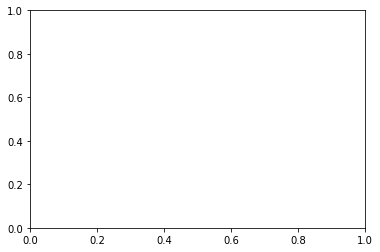

In [198]:
ax = plt.gca(); XYs = [line.get_xydata() for line in ax.lines]

### Embeddings of subgraphs

In [14]:
import karateclub as karate
from sklearn.manifold import TSNE
import itertools

In [37]:
# We need to relabel the nodes since it is a requirement for the karateclub lib
family_relabeled_subgraphs = family_subgraphs.copy()
for family, subgraphs in family_relabeled_subgraphs.items():
    relabeled = []
    for H in subgraphs:
        relabeled.append(
            nx.relabel_nodes(H, dict(zip(H.nodes(), range(H.number_of_nodes()))),
                             copy=True))
    family_relabeled_subgraphs[family]=relabeled


In [44]:
subgraphs[0].nodes[615]

{'full_id': ('5LIL', 0, 'B', (' ', 1, ' '), ('CA', ' ')),
 'depth': 0,
 'bfactor': 55.11,
 'resname': 'MET',
 'coord': array([ 3.25 , 26.244, 69.77 ], dtype=float32),
 'distance': 27.157814025878906,
 'chain': '5LIL_B'}

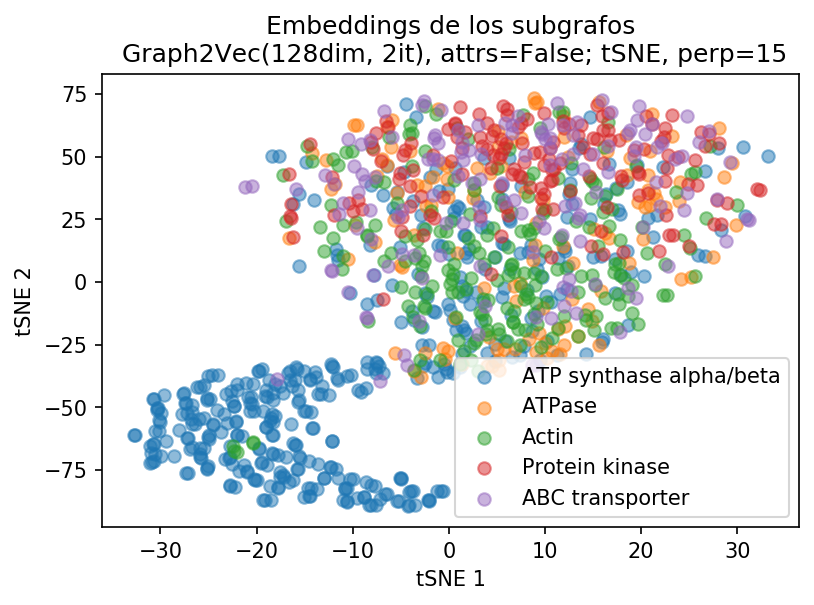

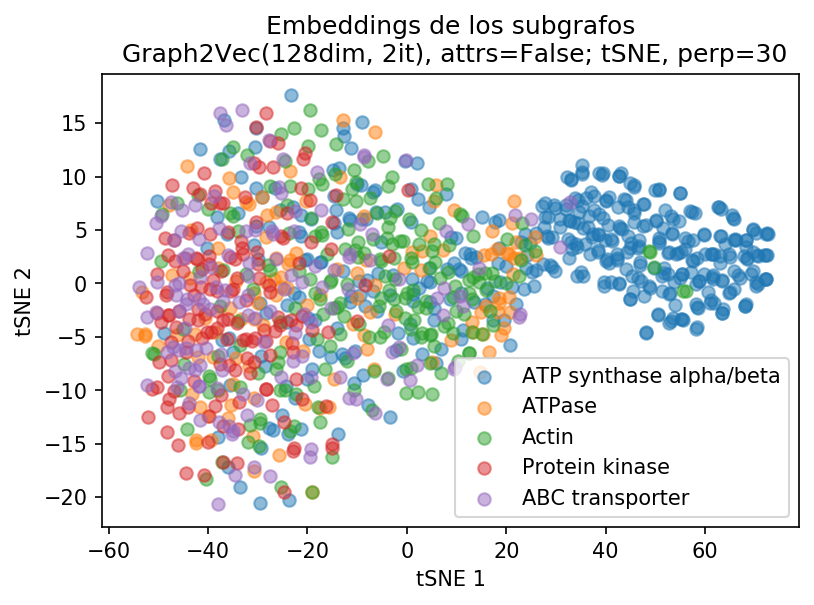

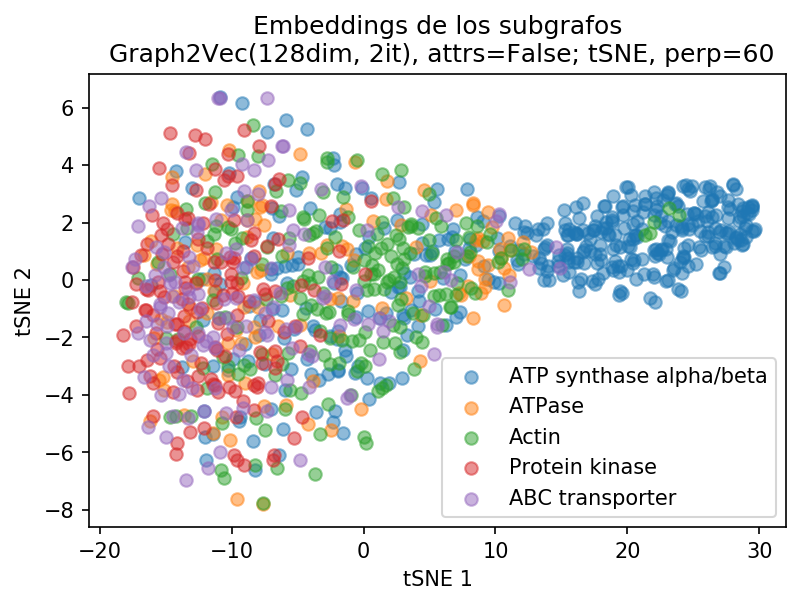

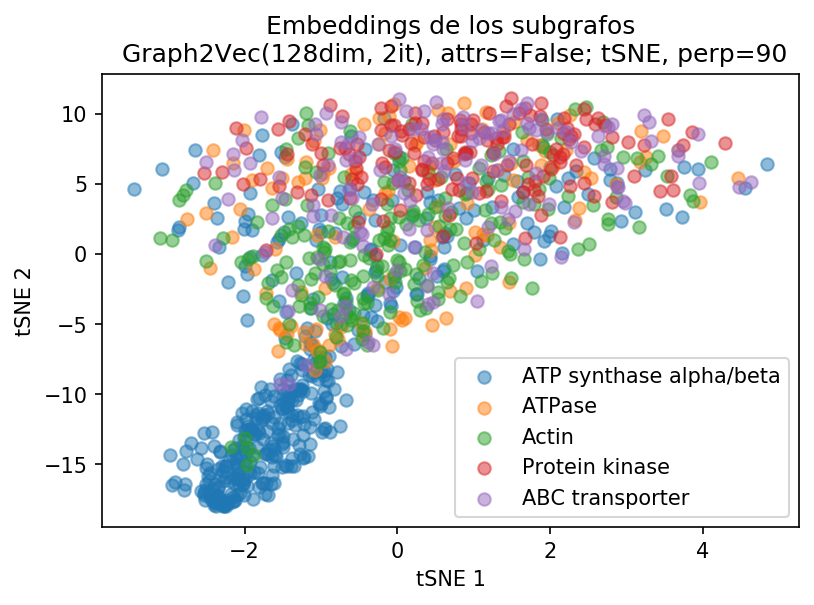

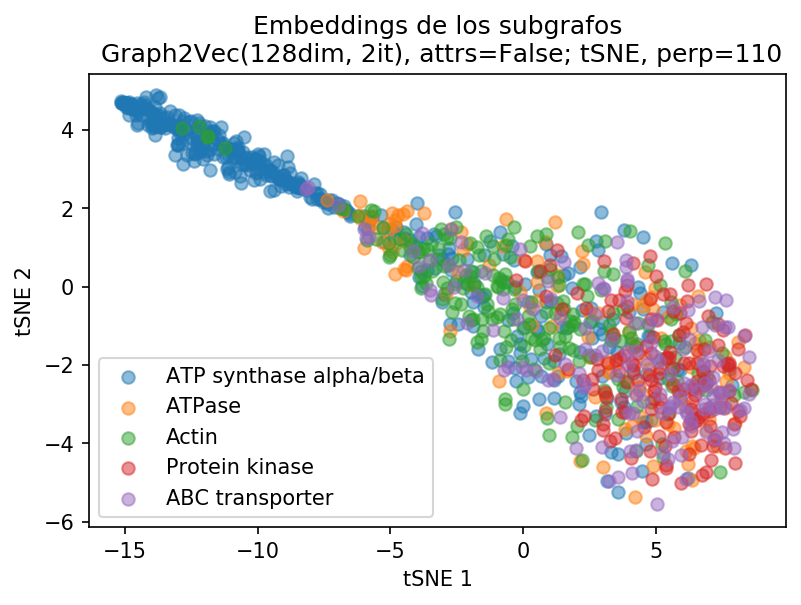

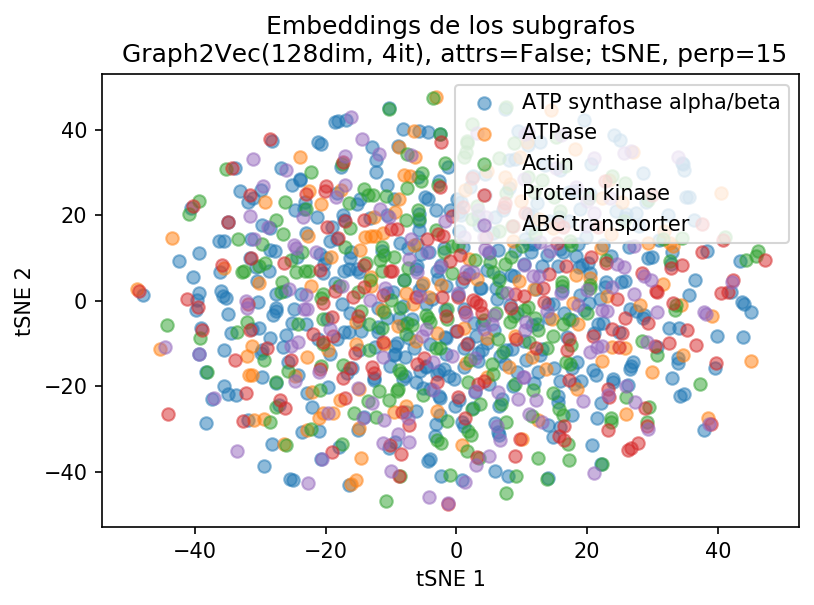

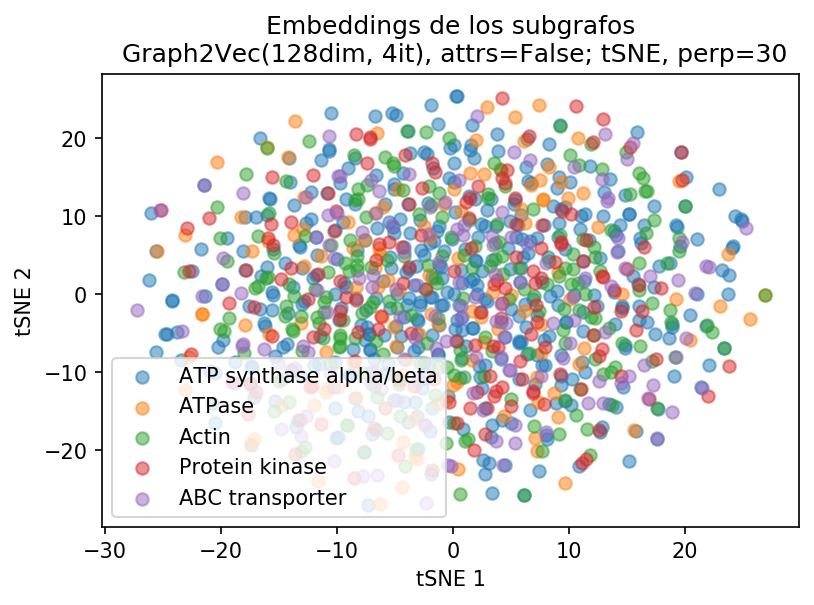

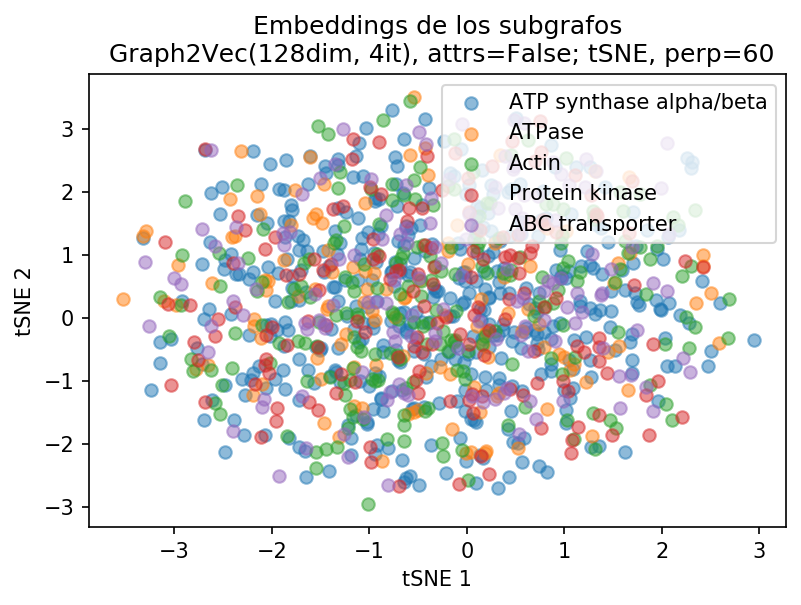

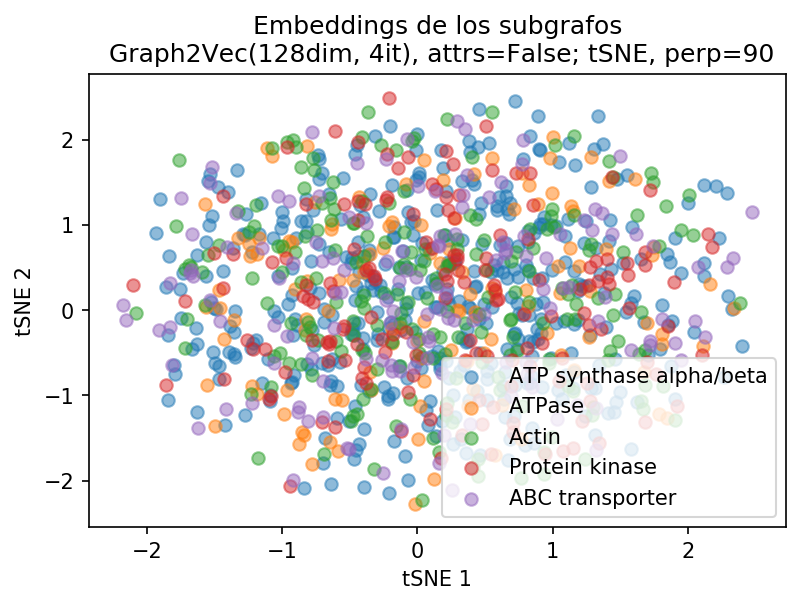

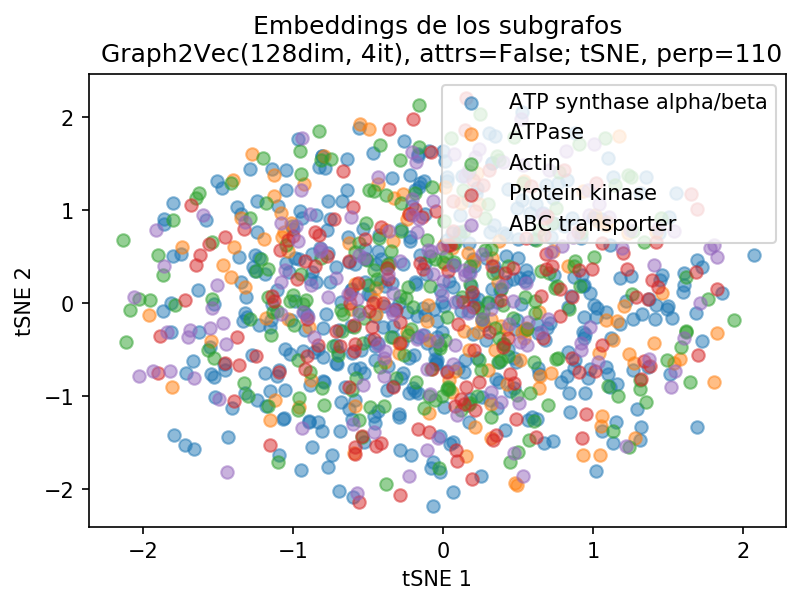

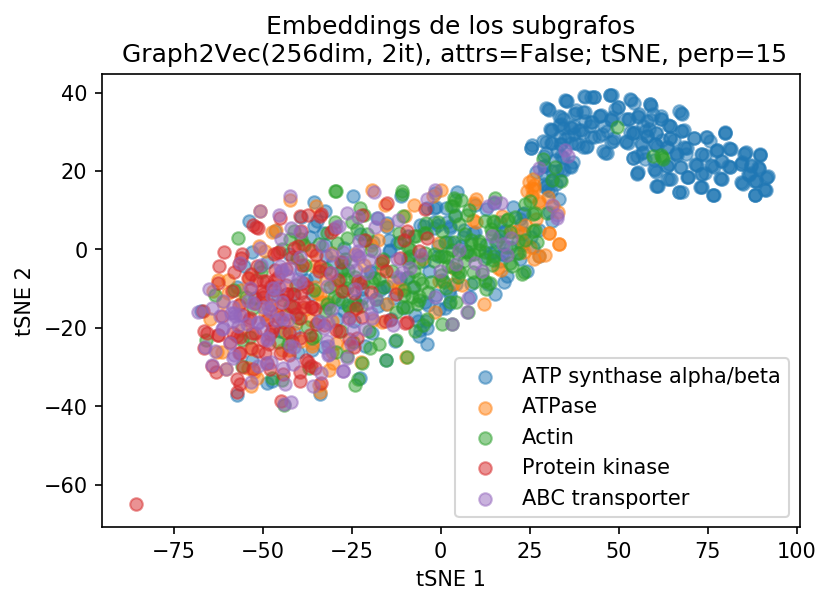

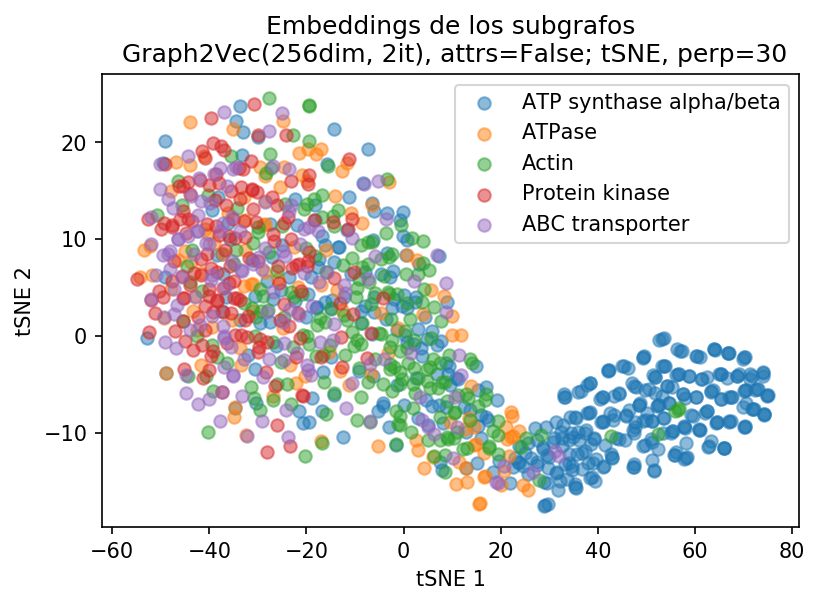

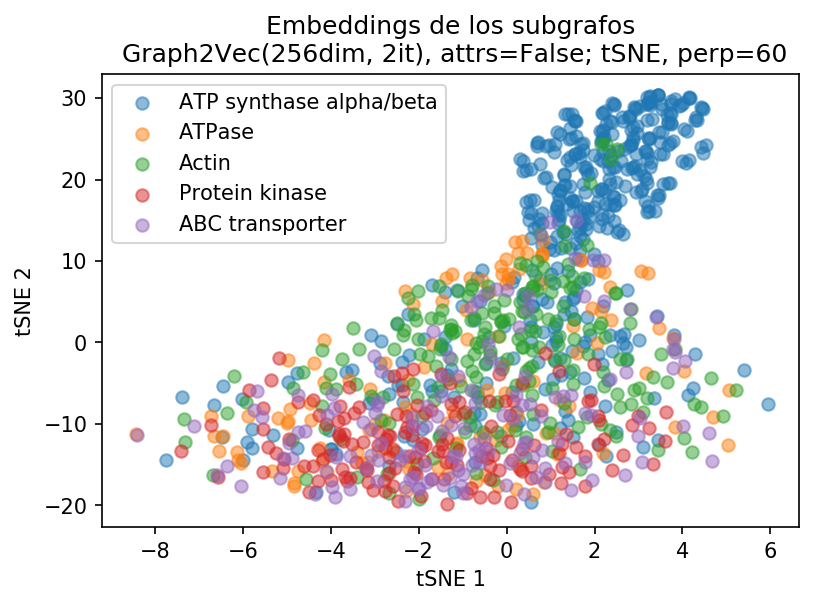

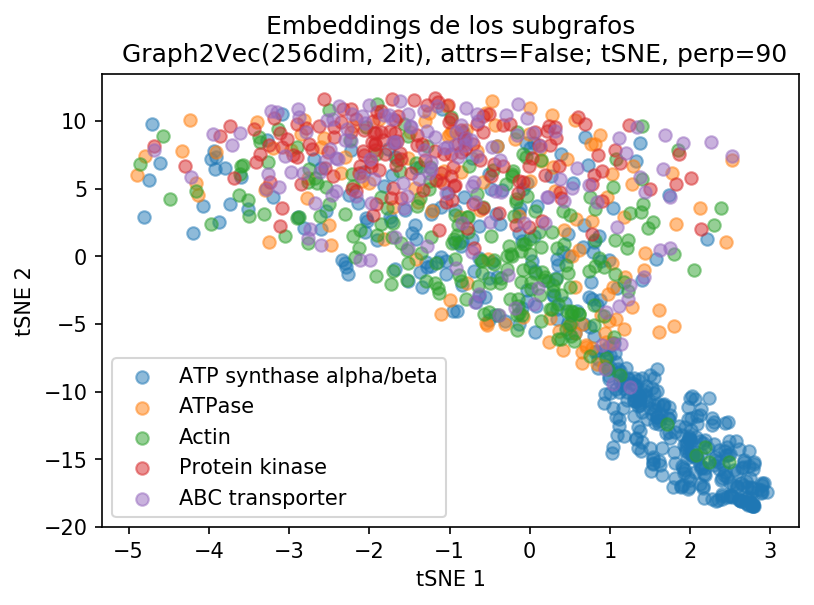

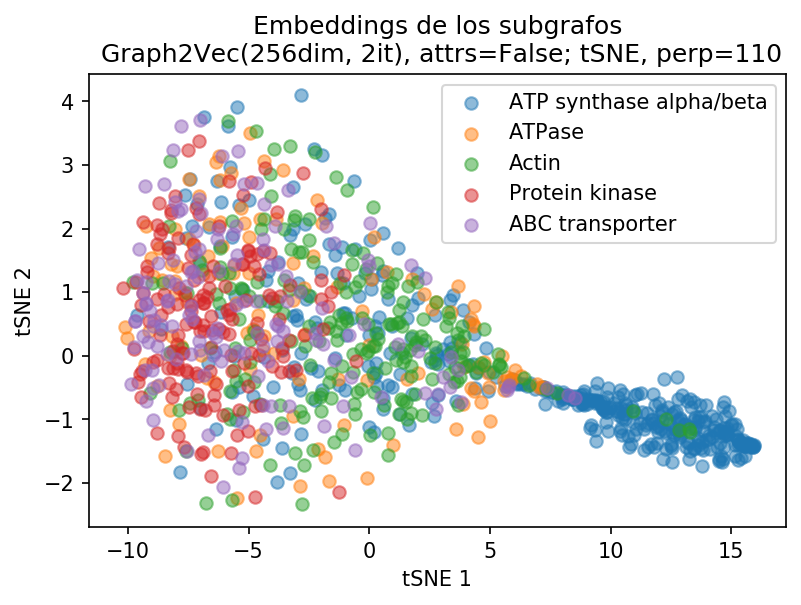

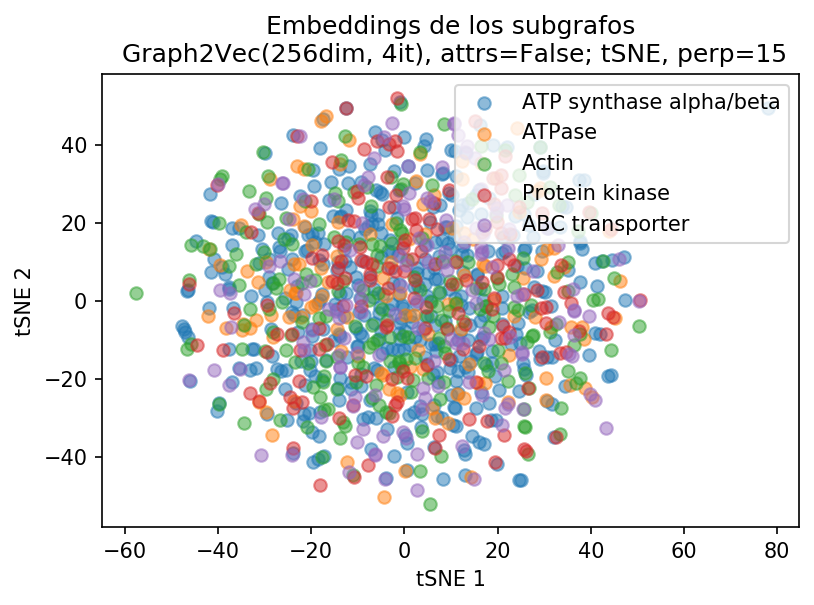

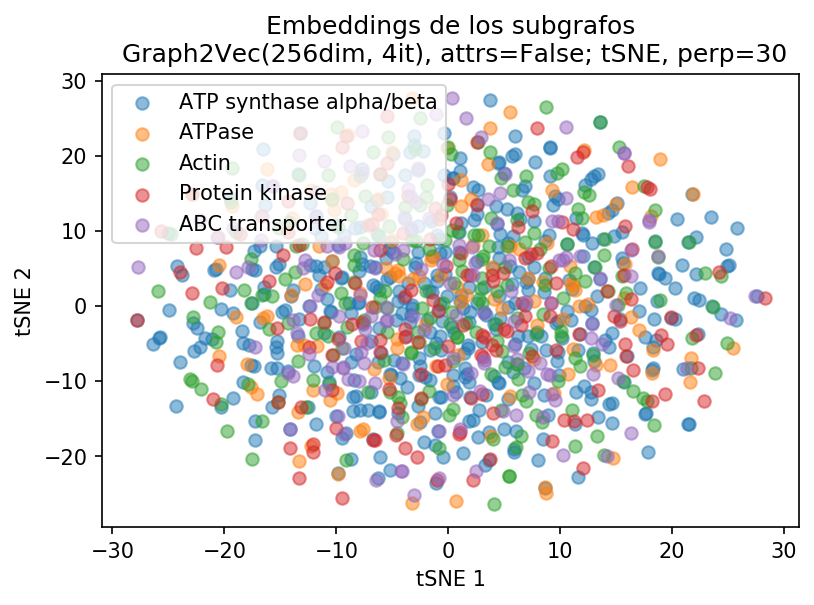

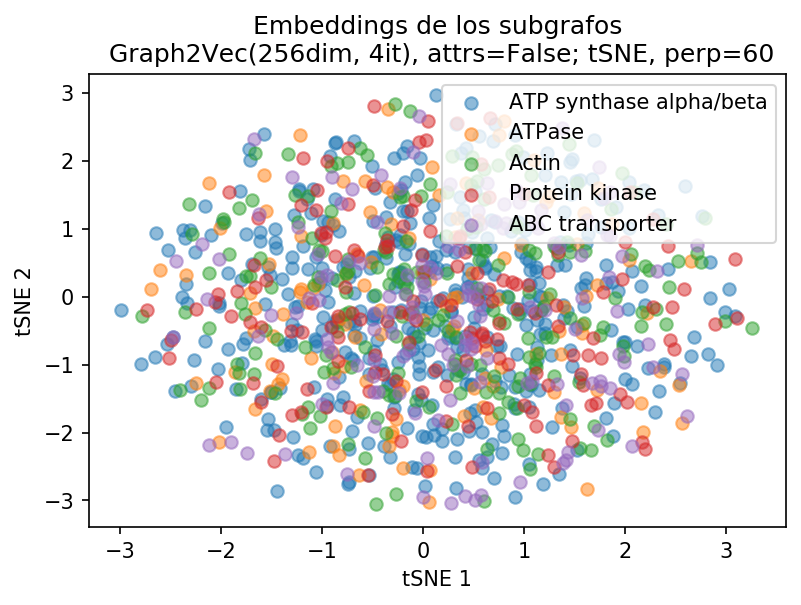

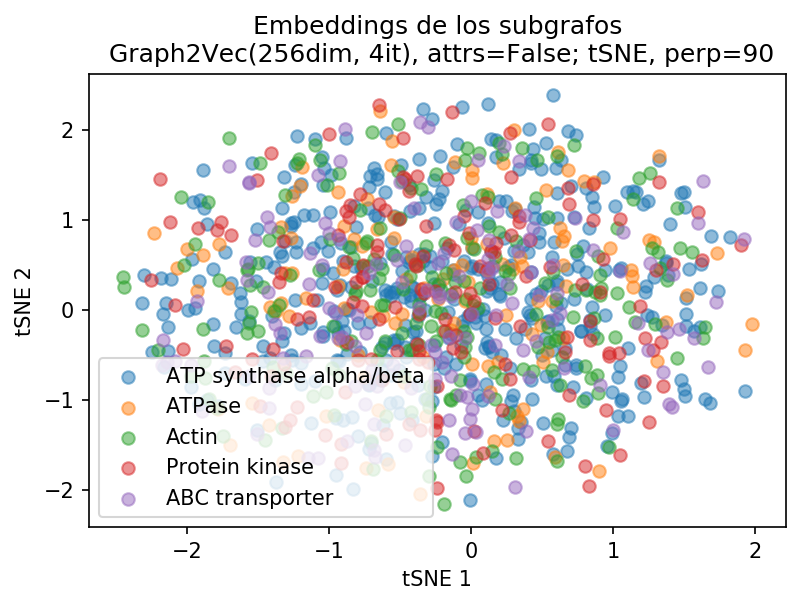

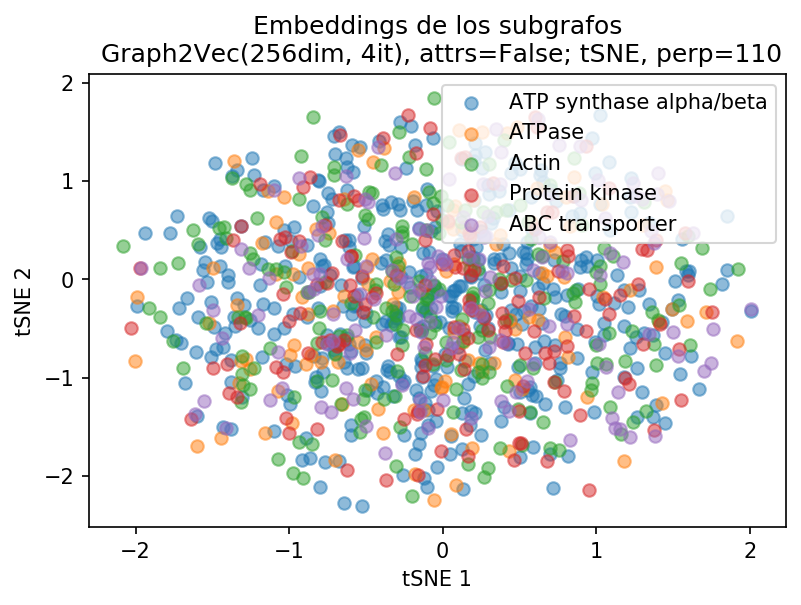

In [45]:
for dimensions, wl_iterations, attributed in itertools.product([128, 256], [2,4], [False]):#TODO: True
    g2v = karate.Graph2Vec(
        attributed=attributed, dimensions=dimensions, workers=8, 
        epochs=10, wl_iterations=wl_iterations, seed=42)
    g2v.fit([H for k in family_relabeled_subgraphs.keys() 
               for H in family_relabeled_subgraphs[k]])
    embs = g2v.get_embedding()
    for perplexity in [15, 30, 60, 90, 110]:
        tSNE = TSNE(n_components=2, perplexity=perplexity)
        embs_xy = tSNE.fit_transform(embs)
        plt.figure(dpi=150, facecolor="white")

        start, stop = 0, 0
        for family, subgraphs in family_relabeled_subgraphs.items():
            stop = start + len(subgraphs)
            family_embeds = embs_xy[start:stop, :]

            plt.scatter(
                #deg,
                family_embeds[:, 0],
                family_embeds[:, 1],
                alpha=0.5,
                label=family_id_name[family]
            )
            start = stop
        plt.title(f"Embeddings de los subgrafos\n Graph2Vec({dimensions}dim, {wl_iterations}it), "
                  f"attrs={attributed}; tSNE, perp={perplexity}")
        plt.xlabel("tSNE 1")
        #plt.ylabel("Betweenness centrality")
        plt.ylabel("tSNE 2")
        plt.legend()
        #plt.xlim(150,700)
        #plt.ylim(500,5000)
        plt.savefig(f"viz/g2v/{dimensions}_{wl_iterations}_{attributed}_{perplexity}.png", dpi=150)

SF as embedding (k lowest eigenvalues of normalized laplacian)

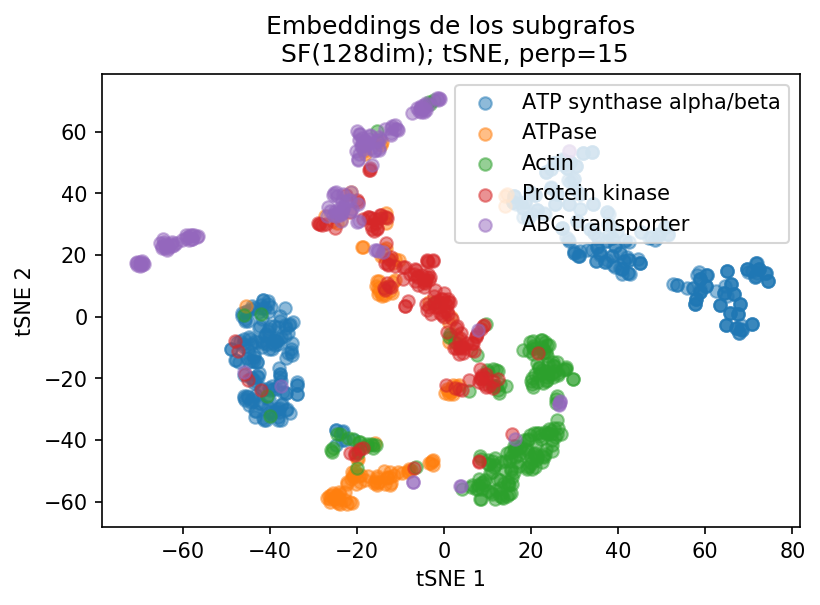

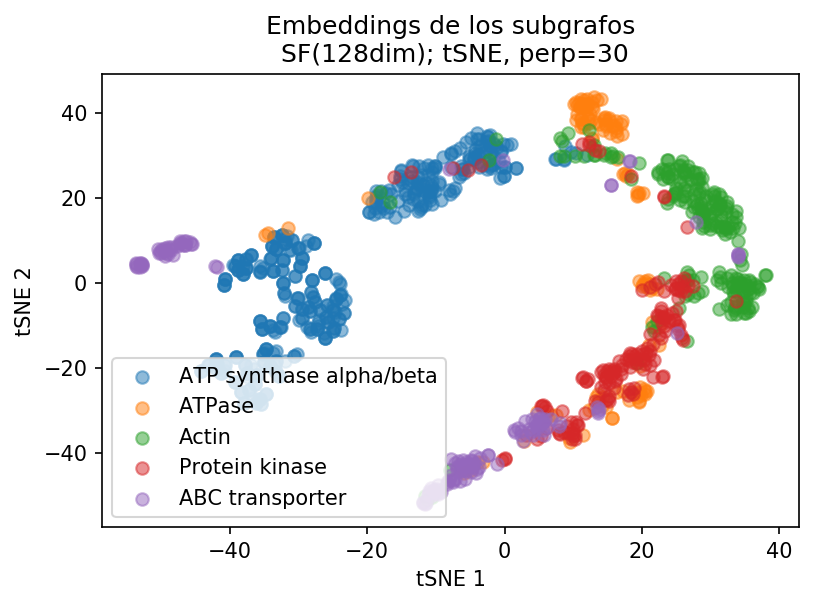

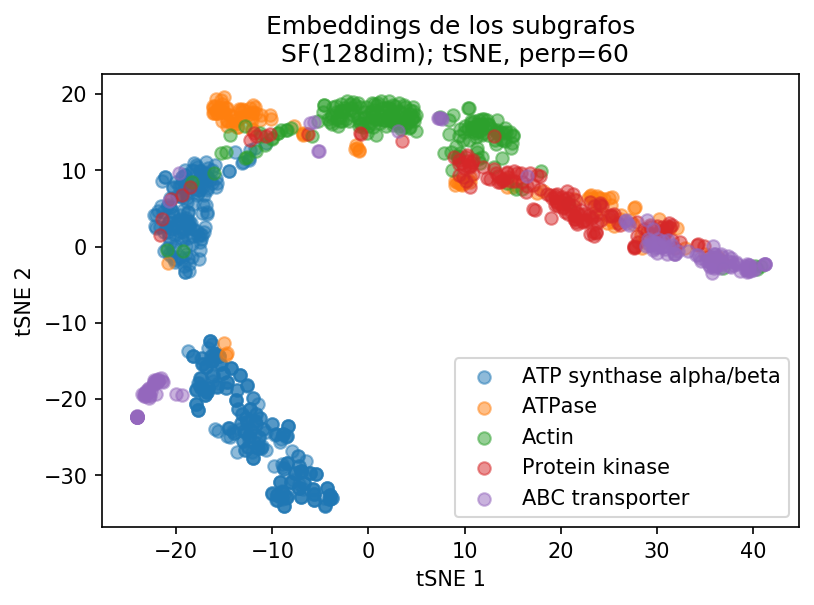

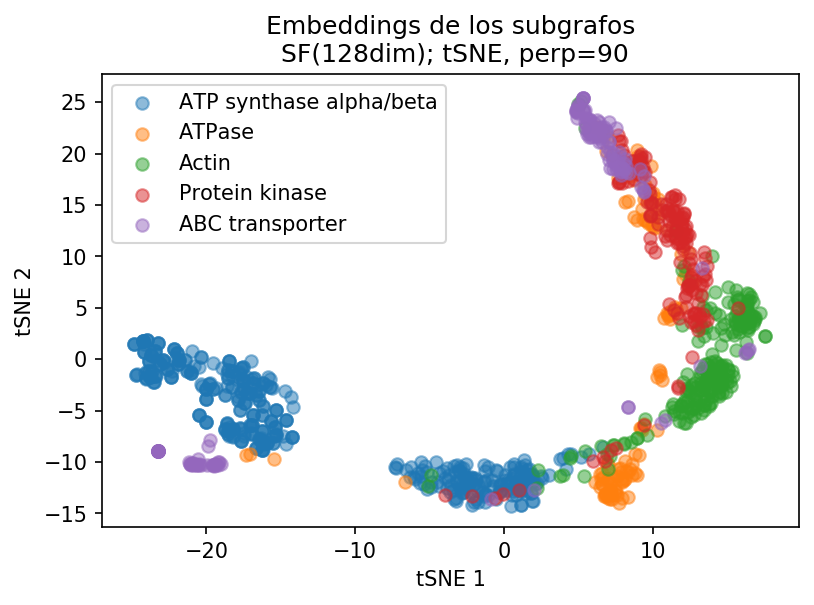

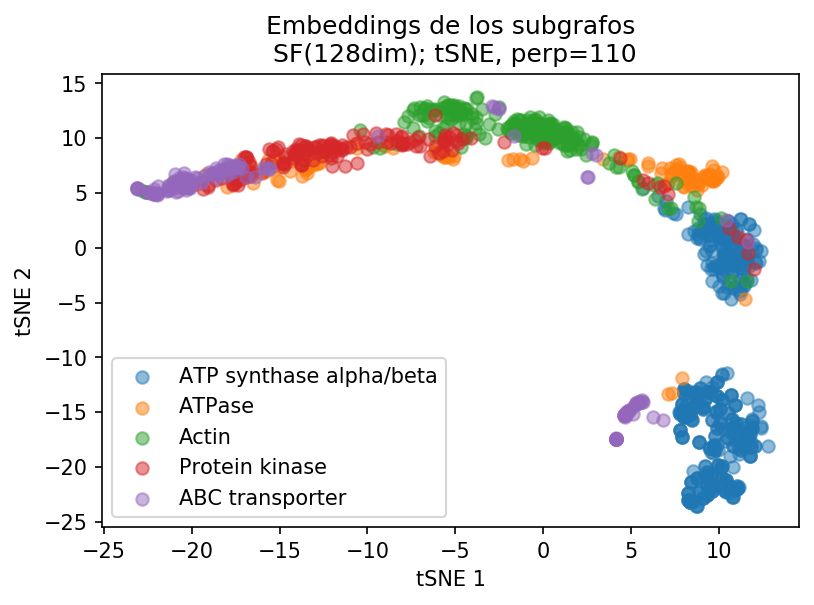

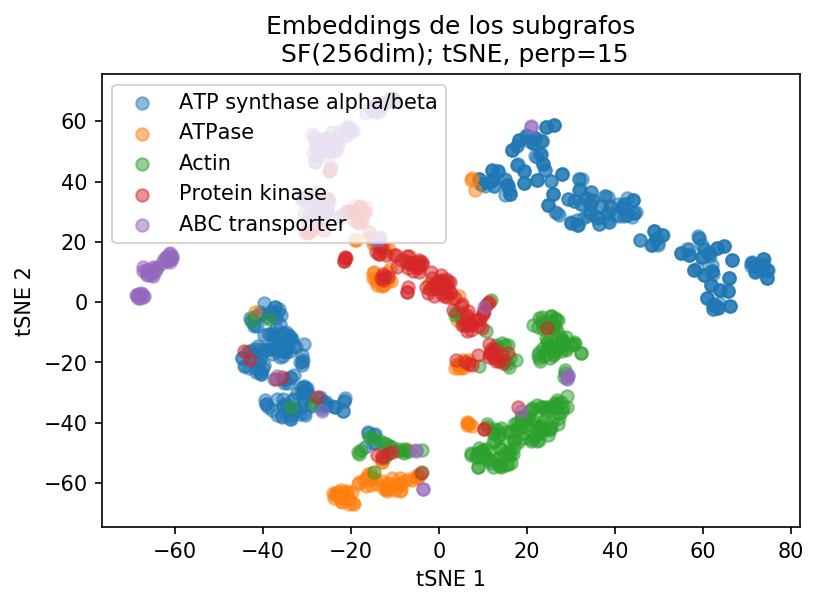

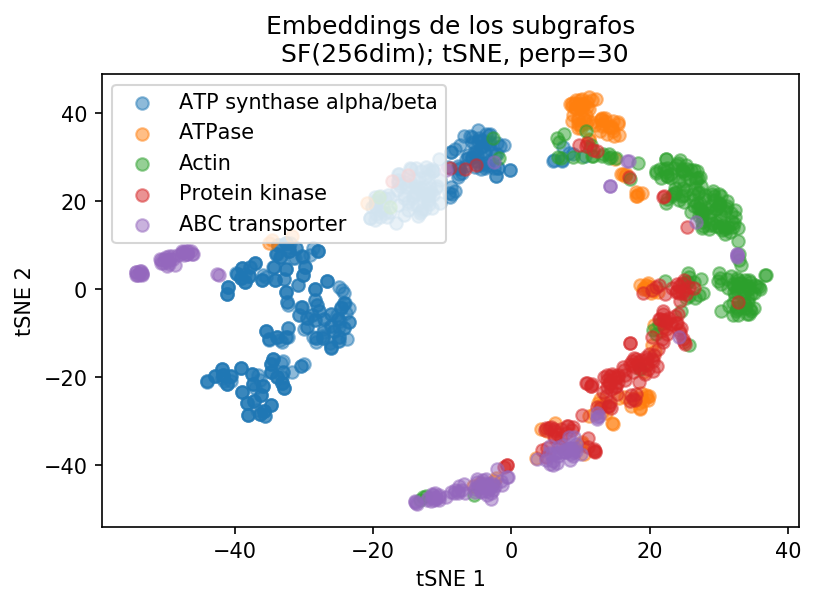

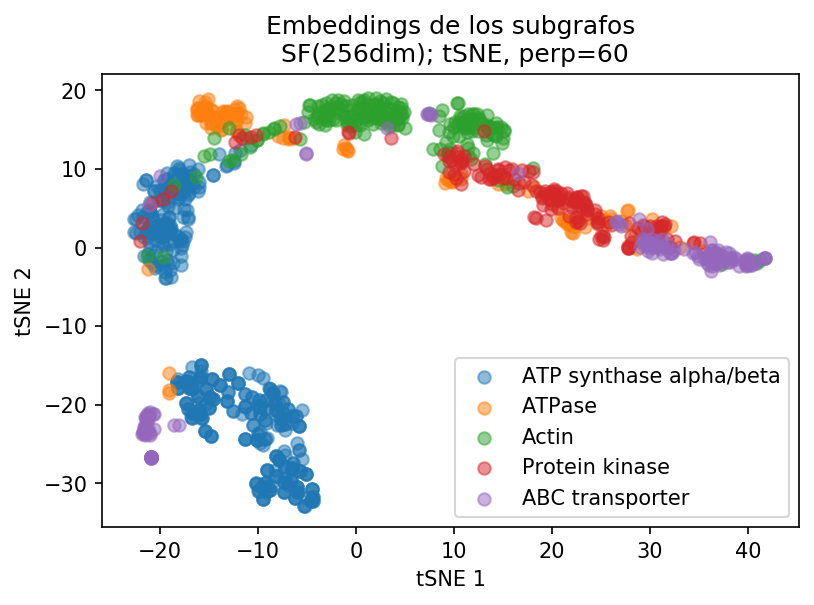

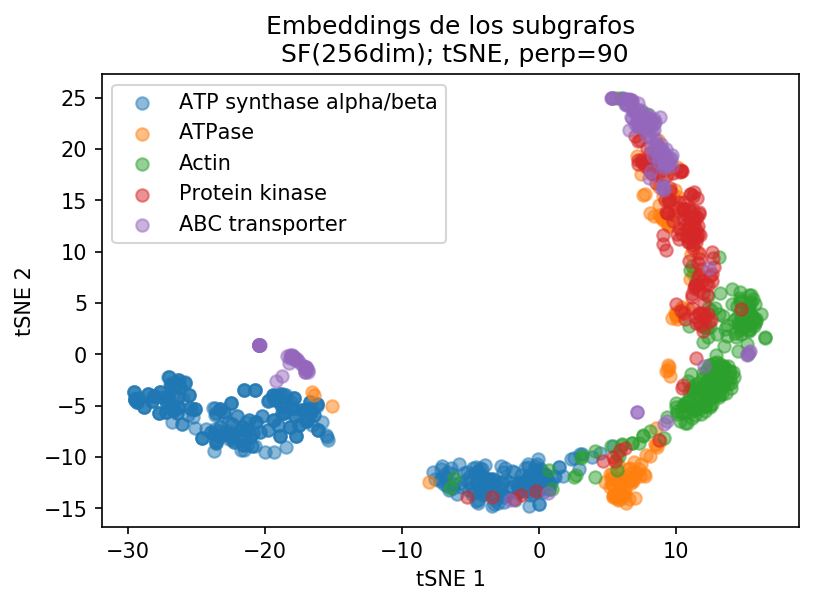

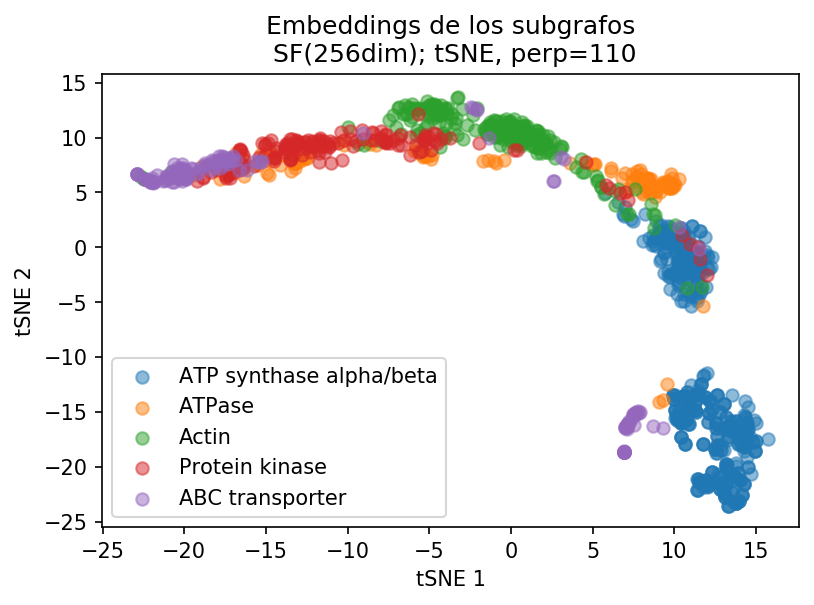

In [47]:
for dimensions in [128, 256]:
    SF = karate.SF(
        dimensions=128)
    SF.fit([H for k in family_relabeled_subgraphs.keys() 
               for H in family_relabeled_subgraphs[k]])
    embs = SF.get_embedding()
    for perplexity in [15, 30, 60, 90, 110]:
        tSNE = TSNE(n_components=2, perplexity=perplexity)
        embs_xy = tSNE.fit_transform(embs)
        plt.figure(dpi=150, facecolor="white")

        start, stop = 0, 0
        for family, subgraphs in family_relabeled_subgraphs.items():
            stop = start + len(subgraphs)
            family_embeds = embs_xy[start:stop, :]

            plt.scatter(
                #deg,
                family_embeds[:, 0],
                family_embeds[:, 1],
                alpha=0.5,
                label=family_id_name[family]
            )
            start = stop
        plt.title(f"Embeddings de los subgrafos\n SF({dimensions}dim)"
                  f"; tSNE, perp={perplexity}")
        plt.xlabel("tSNE 1")
        #plt.ylabel("Betweenness centrality")
        plt.ylabel("tSNE 2")
        plt.legend()
        #plt.xlim(150,700)
        #plt.ylim(500,5000)
        plt.savefig(f"viz/sf/{dimensions}_{perplexity}.png", dpi=150)

In [24]:
12:28:30